 #### **To train a hybrid quantum-classical neural network for binary classification.**
 The quantum circuit is used to extract non-linear features from the input data, and the classical neural network is used to combine these features and make predictions. The code demonstrates how quantum circuits can be integrated with classical neural networks to improve the performance of machine learning models on complex tasks. Based on code from https://pennylane.ai/qml/demos/tutorial_qnn_module_torch/

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 19.3 MB/s eta 0:00:00


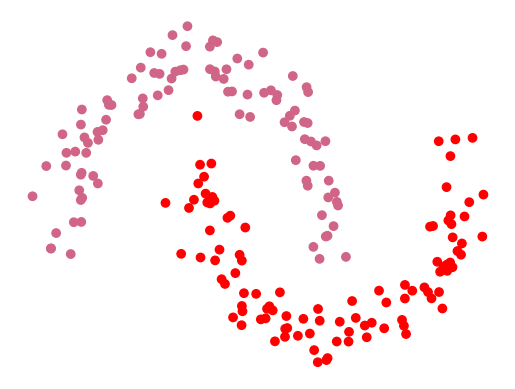

Average loss over epoch 1: 0.7052
Average loss over epoch 2: 0.6961
Average loss over epoch 3: 0.6889
Average loss over epoch 4: 0.6773
Average loss over epoch 5: 0.6596
Accuracy: 87.0%


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic moon-shaped dataset
X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

# Plot the dataset
c = ["#D16587" if y_ == 0 else "#ff0000" for y_ in y]
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

# Define the quantum circuit using PennyLane
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 10
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Define the HybridModel
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = nn.Linear(2, 4)
        self.qlayer_1 = qlayer
        self.qlayer_2 = qlayer
        self.clayer_2 = nn.Linear(4, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Create the model
model = HybridModel()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.2)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training
epochs = 5

for epoch in range(epochs):
    running_loss = 0

    for xs, ys in data_loader:
        optimizer.zero_grad()

        # Forward pass
        loss_evaluated = loss_fn(model(xs), ys)

        # Backward pass
        loss_evaluated.backward()

        # Update weights
        optimizer.step()

        running_loss += loss_evaluated.item()

    avg_loss = running_loss / len(data_loader)
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

# Evaluation
y_pred = model(X_tensor)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")
